In [ ]:
!pip list --format=freeze > ../Build/requirements.txt

# 1. Introducción

Nos encontramos con un dataset que contiene información de ventas de casas, donde se incluye el precio de venta, información relacionada a la venta como el año y la condición y características de cada casa como el area del lote, forma del lote, entre otras.

Mediante la información de este dataset, se puede obtener las variables que pueden ser relevante al precio de venta de forma que, tanto vendedores como compradores, puedan hacer un estimado del valor esperado de venta de una determinada casa, para tomar decisiones mejor informadas en este tipo de transacciones comerciales.

De esta forma, se realizan las siguientes preguntas:
- ¿Cuál es la variable más relevante para determinar el precio de venta de una casa?
- ¿Son estás variables predictores rigurosos, es decir, su coeficiente afecta significativamente el precio de venta?

El objetivo de este proyecto será dar una respuesta a estas preguntas, usando como base el material compartido en clase y el conocimiento adquirido a lo largo de la maestría.

# 2. Descripción y limpieza del dataset

## 2.1 Instalación de módulos

Se instalan los módulos específicados en el archivo requirement.txt para la correcta ejecución del códugo a utilizar.

In [ ]:
!pip install -r ../Build/requirements.txt

## 2.1 Importación de modulos de Python a usar

Durante el proyecto se usarán los siguientes módulos:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.robust.norms import HuberT

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from scipy.stats import shapiro, jarque_bera

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2.2 Lectura del dataset

Se usa pandas para leer el dataset y almacenarlo en un objeto DataFrame que nos permita su manipulación con más facilidad.

In [3]:
path = '../Data/AmesHousing.csv'

df = pd.read_csv(path, delimiter=',')

In [4]:
random_state = 42

## 2.3 Descripción y analisis inicial del dataset
Usamos DataFrame.info() y DataFrame.describe() para obtener una idea inicial del contenido del dataset

De info obtenemos información básica del dataset por cada columna, tal como tipo (numerico o categorico, conocida en pandas como object), nombre de cada columna y numero de datos no nulos.

Tambien obtenemos información global. Observamos que en total tenemos 82 columnas y 2930 entradas, que componen nuestro dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

De 'Describe()' podemos obtener información estadistica de cada columna numerica, como cantidad (sin incluir nulos), promedio, desviación estándar, minimo, máximo y cuartiles.

Vemos que hay columnas que tienen información no relevante, como la columna order, la cual al tener un mínimo de 1 y un máximo de 2930, indica que es una columna de indice.

En nuestra columna objetivo, SalePrice, observamos un promedio de precio de venta de 180mil, con una desviación estandar de casi 80mil. El 50% de los valores están por debajo de los 160mil.

In [6]:
df.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


También imprimimos en pantalla las primeras 10 filas para obtener una idea visual del contenido del dataframe

In [7]:
df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


Confirmamos nuestra teoría respecto a Order, que parece ser una columna indice, por lo cual la colocamos como indice de nuestro dataset.

In [8]:
df = df.set_index('Order')

## 2.4 Limpieza del dataset

Para la limpieza del dataset, se realizan las siguientes transformaciones:

__1. Limpieza de valores nulos__
Esta limpieza se realiza de acuerdo al tipo de dato:
* Dato numéricos: Se reemplazan los nulos con la mediana
* Datos categoricos: Se reemplaza por una nueva categoría 'No Aplica', debido a que variables como alley, fence, etc. parece indicar que se usa nan para el caso que no se encuentre el objeto por la categoría en la casa, por ejemplo, la casa no tiene cerca.

__2. Transformación logarítmica__
Aplicamos np.log1p(x) (log(1+x)) a las columnas numéricas que cumplan la siguiente condición: Todos los valores sean no negativos, y cuyo coeficiente de asimetría (skewness) sea mayor a 1 o menor que -1 (alta asimetría).

__3. Tratamiento de variables categoricas__
Aplicamos one-hot-encoding a las variables categoricas, creando tantas columnas con valores 0 y 1, de acuerdo a si aplica o no, para cada categoría. Finalmente, unimos reemplamos las columnas creadas por las originales en el dataset.

In [9]:
# =============================
# 1. Limpieza de valores nulos
# =============================
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        # Reemplazar nulos numéricos con la mediana
        df[col].fillna(df[col].median(), inplace=True)
    else:
        # Reemplazar nulos categóricos con 'Sin categoria'
        df[col].fillna("Sin categoria", inplace=True)

print("Valores nulos restantes:", df.isnull().sum().sum())

# =============================
# 2. Transformación logarítmica
# =============================
# Calcular skewness para decidir qué variables transformar
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

skewed = df[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features = skewed[abs(skewed) > 1].index

print(f"\nVariables con alta asimetría (|skew| > 1): {list(skewed_features)}")

# Aplicar log(1+x) solo a variables no negativas
for col in skewed_features:
    if (df[col] >= 0).all():
        df[col] = np.log1p(df[col])

print("Transformación logarítmica aplicada a variables numéricas sesgadas.")

# =============================
# 3. Codificación de variables categóricas
# =============================
cat_cols = df.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[cat_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

df_final = pd.concat([df[num_cols].reset_index(drop=True), encoded_df], axis=1)

print("\nForma final del dataset:", df_final.shape)
print("Dataset limpio, sin nulos, sin outliers, con transformación log y codificación categórica.")


Valores nulos restantes: 0

Variables con alta asimetría (|skew| > 1): ['Misc Val', 'Pool Area', 'Lot Area', 'Low Qual Fin SF', '3Ssn Porch', 'Kitchen AbvGr', 'BsmtFin SF 2', 'Enclosed Porch', 'Screen Porch', 'Bsmt Half Bath', 'Mas Vnr Area', 'Open Porch SF', 'Wood Deck SF', 'SalePrice', 'Lot Frontage', '1st Flr SF', 'BsmtFin SF 1', 'MS SubClass', 'Gr Liv Area', 'Total Bsmt SF']
Transformación logarítmica aplicada a variables numéricas sesgadas.

Forma final del dataset: (2930, 321)
Dataset limpio, sin nulos, sin outliers, con transformación log y codificación categórica.


------------------------------------------------------------------------------------------------------------
Finalmente nos queda el siguiente dataset:

In [10]:
df_final

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,526301100,3.044522,4.955827,10.366309,6,5,1960,1960,4.727388,6.461468,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,526350040,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,526351010,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,526353030,3.044522,4.543295,9.320181,7,5,1968,1968,0.000000,6.971669,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,527105010,4.110874,4.317488,9.534668,5,5,1997,1998,0.000000,6.674561,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,923275080,4.394449,3.637586,8.979417,6,6,1984,1984,0.000000,6.709304,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2926,923276100,3.044522,4.234107,9.092232,5,5,1983,1983,0.000000,5.710427,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2927,923400125,4.454347,4.143135,9.253591,5,5,1992,1992,0.000000,5.823046,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2928,924100070,3.044522,4.356709,9.211440,5,5,1974,1975,0.000000,6.977281,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
df_final['Garage Area']

0       528.0
1       730.0
2       312.0
3       522.0
4       482.0
        ...  
2925    588.0
2926    484.0
2927      0.0
2928    418.0
2929    650.0
Name: Garage Area, Length: 2930, dtype: float64

Y las siguientes columnas:

In [12]:
for column in df_final.columns:
    print(column)

PID
MS SubClass
Lot Frontage
Lot Area
Overall Qual
Overall Cond
Year Built
Year Remod/Add
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Garage Yr Blt
Garage Cars
Garage Area
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Misc Val
Mo Sold
Yr Sold
SalePrice
MS Zoning_A (agr)
MS Zoning_C (all)
MS Zoning_FV
MS Zoning_I (all)
MS Zoning_RH
MS Zoning_RL
MS Zoning_RM
Street_Grvl
Street_Pave
Alley_Grvl
Alley_Pave
Alley_Sin categoria
Lot Shape_IR1
Lot Shape_IR2
Lot Shape_IR3
Lot Shape_Reg
Land Contour_Bnk
Land Contour_HLS
Land Contour_Low
Land Contour_Lvl
Utilities_AllPub
Utilities_NoSeWa
Utilities_NoSewr
Lot Config_Corner
Lot Config_CulDSac
Lot Config_FR2
Lot Config_FR3
Lot Config_Inside
Land Slope_Gtl
Land Slope_Mod
Land Slope_Sev
Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neig

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Columns: 321 entries, PID to Sale Condition_Partial
dtypes: float64(308), int64(13)
memory usage: 7.2 MB


In [14]:
df_final.describe()

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
count,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,7.144645e+08,3.824262,4.201376,9.092342,6.094881,5.563140,1971.356314,1984.266553,2.073303,4.233941,...,0.081570,0.002389,0.000341,0.865529,0.064846,0.004096,0.008191,0.015700,0.823549,0.083618
std,1.887308e+08,0.693861,0.321038,0.511054,1.411026,1.111537,30.245361,20.860286,2.619556,2.979927,...,0.273755,0.048828,0.018474,0.341216,0.246297,0.063876,0.090149,0.124332,0.381268,0.276861
min,5.263011e+08,3.044522,3.091042,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.284770e+08,3.044522,4.110874,8.914794,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5.354536e+08,3.931826,4.234107,9.152446,6.000000,5.000000,1973.000000,1993.000000,0.000000,5.916202,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.071811e+08,4.262680,4.369448,9.354982,7.000000,6.000000,2001.000000,2004.000000,5.098337,6.599870,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.007100e+09,5.252273,5.749393,12.279537,10.000000,9.000000,2010.000000,2010.000000,7.378384,8.638525,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 3. Análisis Exploratorio de Datos



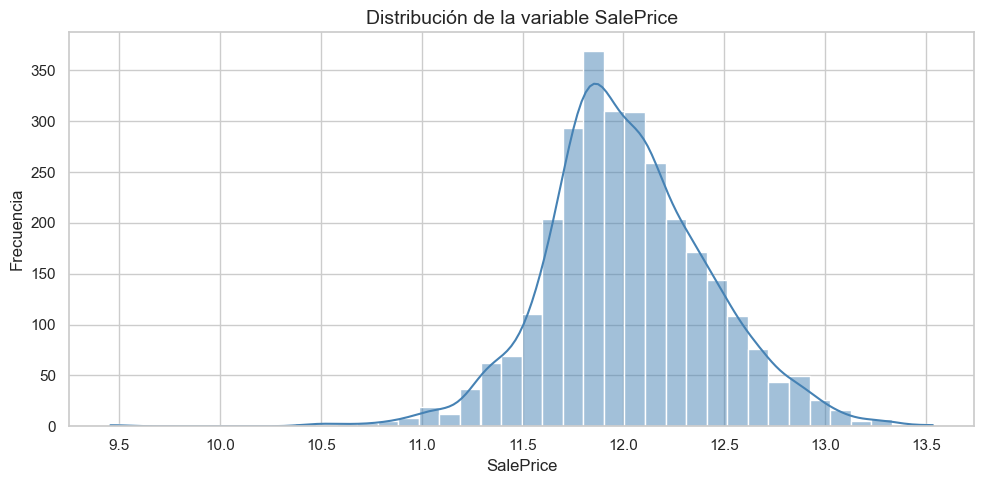

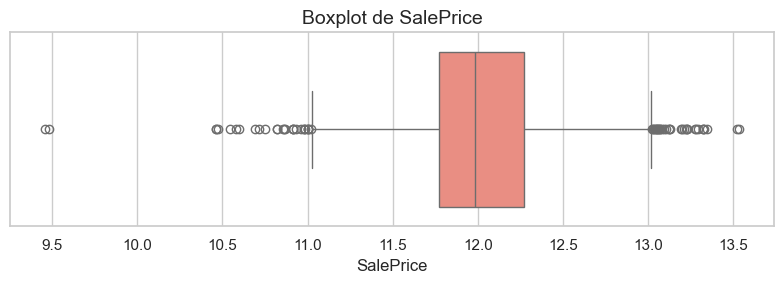

In [15]:
# =============================
# 1. Histograma de SalePrice
# =============================
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(10,5))
sns.histplot(df['SalePrice'], bins=40, kde=True, color='steelblue')
plt.title("Distribución de la variable SalePrice", fontsize=14)
plt.xlabel("SalePrice")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# =============================
# 2. Boxplot de SalePrice
# =============================
plt.figure(figsize=(8,3))
sns.boxplot(x=df_final['SalePrice'], color='salmon')
plt.title("Boxplot de SalePrice", fontsize=14)
plt.xlabel("SalePrice")
plt.tight_layout()
plt.show()


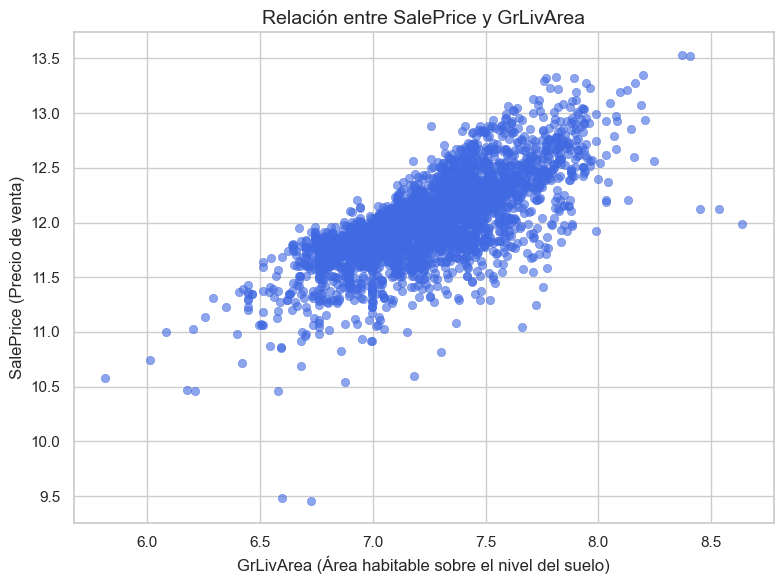

In [16]:
# =============================
# Scatter Plot
# =============================
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(8,6))
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df_final, color='royalblue', alpha=0.6, edgecolor=None)

plt.title("Relación entre SalePrice y GrLivArea", fontsize=14)
plt.xlabel("GrLivArea (Área habitable sobre el nivel del suelo)")
plt.ylabel("SalePrice (Precio de venta)")
plt.tight_layout()
plt.show()


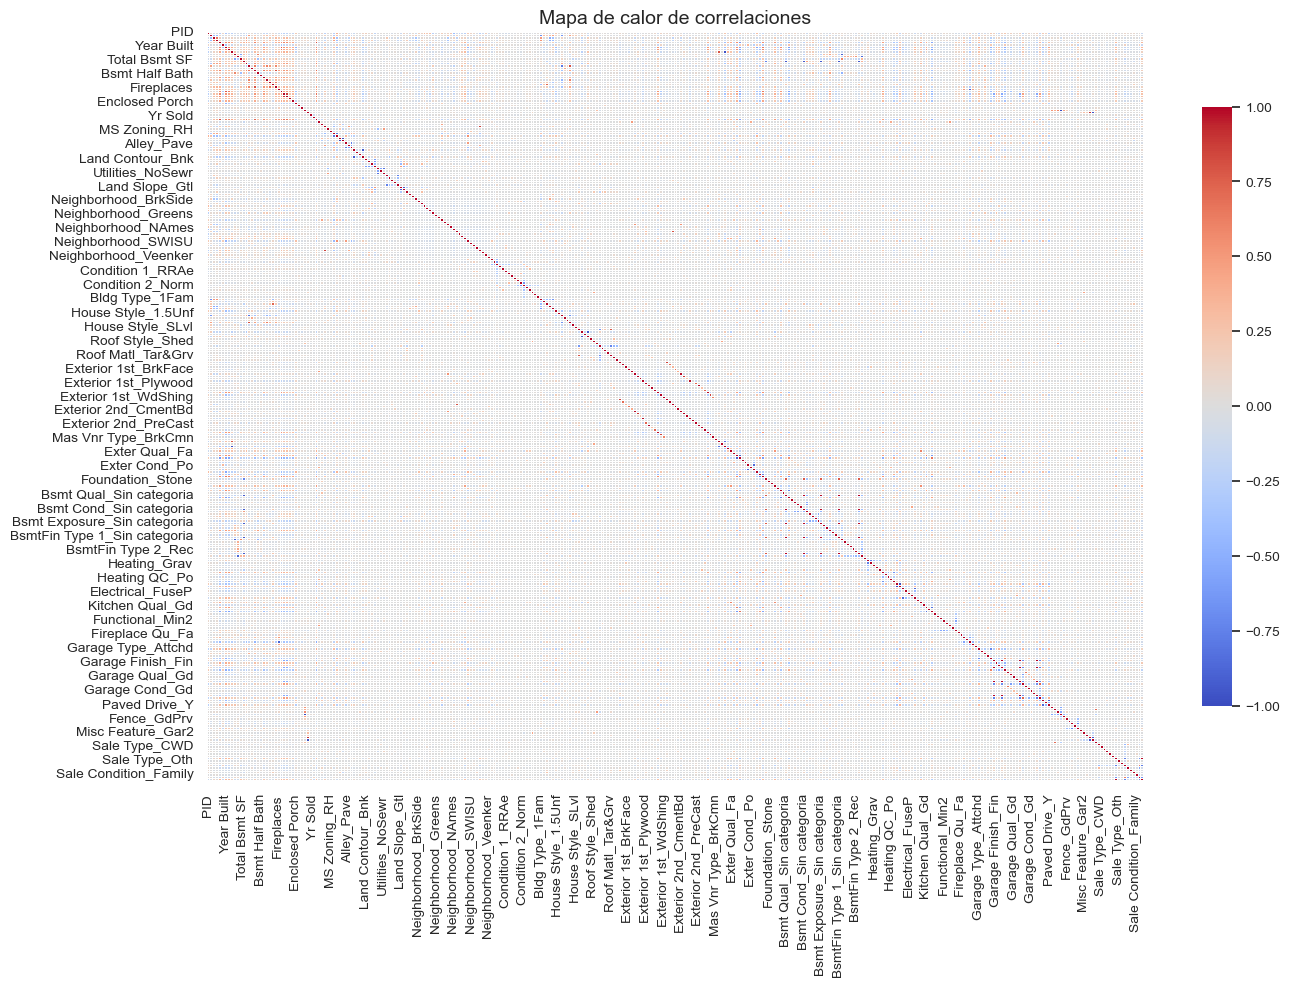

In [17]:
# =============================
# Heatmap
# =============================

corr_matrix = df_final.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.set(style="white", font_scale=0.9)

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,      # Cambia a True si quieres ver los valores numéricos
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Mapa de calor de correlaciones", fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
# Mostrar las variables más correlacionadas con SalePrice
target_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print("\nVariables más correlacionadas con SalePrice:")
print(target_corr.head(20))


Variables más correlacionadas con SalePrice:
SalePrice             1.000000
Overall Qual          0.825645
Gr Liv Area           0.723164
Garage Cars           0.675276
Garage Area           0.651123
Year Built            0.615485
1st Flr SF            0.613423
Year Remod/Add        0.586153
Full Bath             0.577335
Foundation_PConc      0.544291
Garage Yr Blt         0.540362
Exter Qual_Gd         0.500054
Bsmt Qual_Ex          0.492793
TotRms AbvGrd         0.492580
Fireplaces            0.488945
Heating QC_Ex         0.481397
Open Porch SF         0.462735
BsmtFin Type 1_GLQ    0.457372
Mas Vnr Area          0.434237
Kitchen Qual_Ex       0.433435
Name: SalePrice, dtype: float64


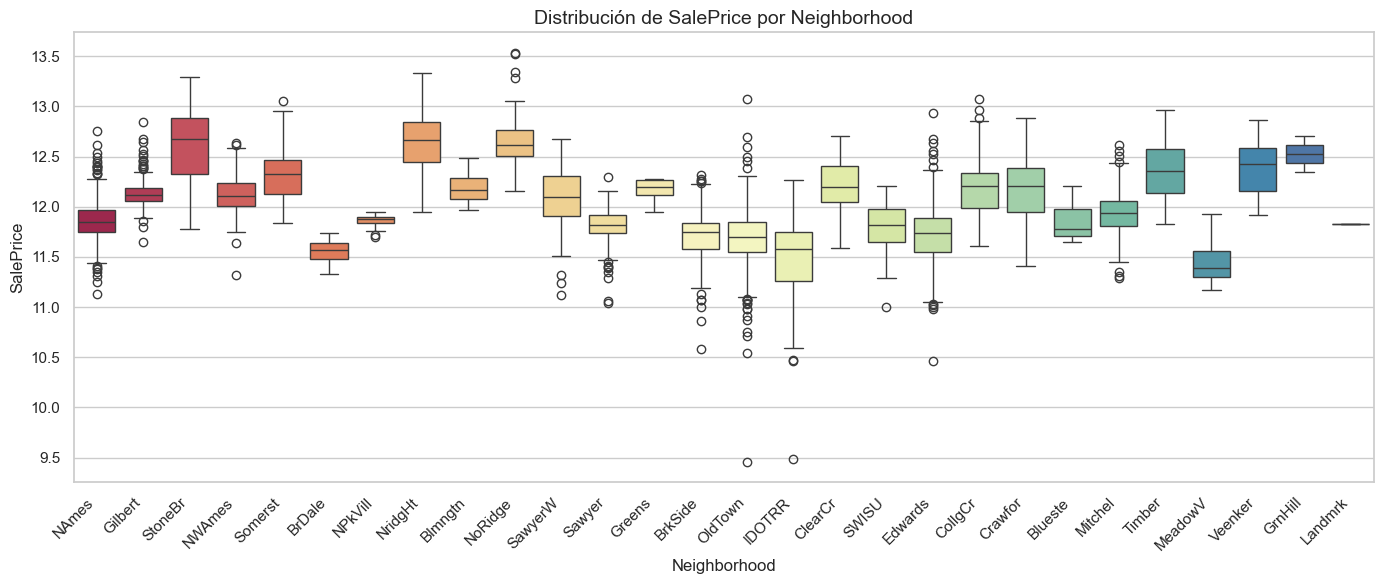

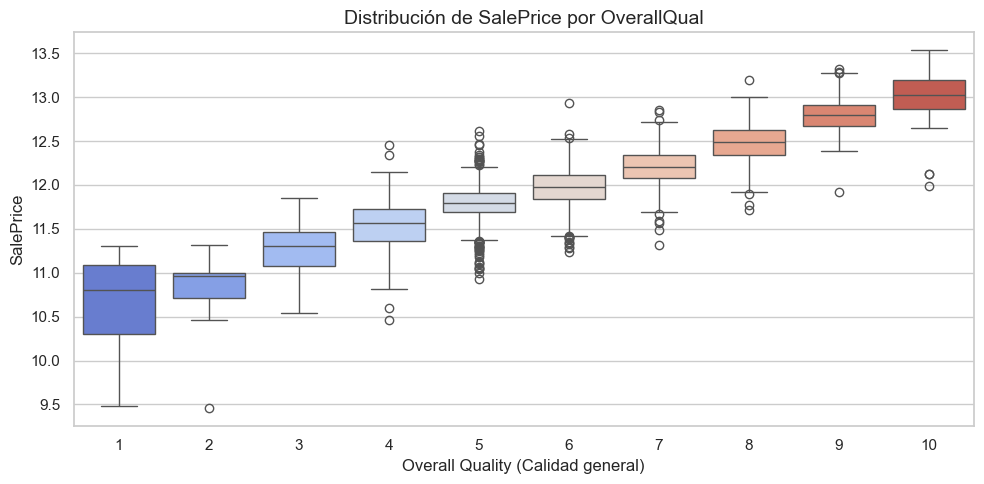

In [19]:
sns.set(style="whitegrid", palette="Set2")

# =============================
# Boxplot SalePrice vs Neighborhood
# =============================
plt.figure(figsize=(14,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df, palette='Spectral')
plt.title("Distribución de SalePrice por Neighborhood", fontsize=14)
plt.xlabel("Neighborhood")
plt.ylabel("SalePrice")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =============================
# Boxplot SalePrice vs OverallQual
# =============================
plt.figure(figsize=(10,5))
sns.boxplot(x='Overall Qual', y='SalePrice', data=df, palette='coolwarm')
plt.title("Distribución de SalePrice por OverallQual", fontsize=14)
plt.xlabel("Overall Quality (Calidad general)")
plt.ylabel("SalePrice")
plt.tight_layout()
plt.show()


En base al analisis realizado, se decide escoger las siguientes variables:
* Overall Qual
* Gr Liv Area
* Garage Cars
* Garage Area
* Year Built
* 1st Flr SF
* Year Remod/Add
* Full Bath
* Foundation_PConc
* Garage Yr Blt
* Exter Qual_Gd

El criterio usado para escoger estas variables es todas las variables cuyo factor de correlación sea superior a 0.5

In [20]:
pd.Series(target_corr).where(lambda x : x>0.5).dropna()

SalePrice           1.000000
Overall Qual        0.825645
Gr Liv Area         0.723164
Garage Cars         0.675276
Garage Area         0.651123
Year Built          0.615485
1st Flr SF          0.613423
Year Remod/Add      0.586153
Full Bath           0.577335
Foundation_PConc    0.544291
Garage Yr Blt       0.540362
Exter Qual_Gd       0.500054
Name: SalePrice, dtype: float64

Adicionalmente, realizamos limpieza de outliers en las columnas escogidas:

In [21]:
# =============================
# Limpieza de outliers
# =============================
before = len(df_final)
columns = list(pd.Series(target_corr).where(lambda x : x>0.5).dropna().index)

for col in columns:
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar filas dentro de los límites
    
    df_final = df_final[(df_final[col] >= lower_bound) & (df_final[col] <= upper_bound)]

after = len(df_final)    
print(f"{col}: {before - after} filas eliminadas ({(before - after)/before:.2%})")

Exter Qual_Gd: 134 filas eliminadas (4.57%)


# 4. Formulación matricial del modelo OLS (Mínimos cuadrados)

Para la formulación matricial del modelo lineal se expresa de la siguiente manera:

### <p style="text-align:center;">$XB = Y$</p>

Donde:
* __B__ es una matriz de coeficientes de tamaño mx1, que contiene los coeficientes $B_0, B_1,...,B_{m-1}$
* __X__ es una matriz de variables regresoras de tamaño nxm, donde la primera columna de cada fila debe tener valor 1, y el resto de valores corresponde a los $m-1$ atributos que serán usados para determinar Y, para cada una de las n observaciones.
* __Y__ es una matriz de tamaño nx1, que contendra las n predicciones de la variable objetivo __Y__

Para obtener el valor de la matriz B, se sigue el siguiente  proceso de despeje:
* Multiplicar ambos lados de la ecuación por $X^T$

### <p style="text-align:center;">$(X^TX)B = X^TY$</p>

* Como se podrá observar, la matriz $(X^TX)$ es una matriz cuadrada de tamaño mxm. Siendo una matriz cuadrada, y asumiendo que se cumple el criterio invertibilidad, donde el determinante debe ser distinto de 0 (luego discutiremos lo que implica que el determinante sea distinto de 0), podemos multiplicar ambos lados de la ecuación por $(X^TX)^{-1}$, para despejar B.

### <p style="text-align:center;">$(X^TX)^{-1}(X^TX)B = (X^TX)^{-1}X^TY$</p>

Dado que $(X^TX)^{-1}(X^TX) = 1$

### <p style="text-align:center;">$B = (X^TX)^{-1}X^TY$</p>


Ahora bien, para que el determinante de (X^TX) sea distinto de 0 y, por tanto, sea invertible, todas las n filas de observaciones deben ser linealmente independientes las unas contras, es decir, no pude existir una combinación lineal tal que al aplicarlas a una de las observaciones se obtenga como resultado otra de las observaciones.

Expresado en terminos más simples, cada observación debe ser independiente de la otra, y no puede existir correlaciones entre ellas.

En base a esta discusión, armamos nuestra matriz X y Y:

In [22]:
# =============================
# Defining Regressor columns
# =============================
regressor_columns = list(pd.Series(target_corr).where(lambda x : x>0.5).dropna().index)
regressor_columns.remove('SalePrice')

regressor_columns

['Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Garage Area',
 'Year Built',
 '1st Flr SF',
 'Year Remod/Add',
 'Full Bath',
 'Foundation_PConc',
 'Garage Yr Blt',
 'Exter Qual_Gd']

In [23]:
# =============================
# Defining target column
# =============================
target_column = 'SalePrice'

target_column

'SalePrice'

In [24]:
# =============================
# X matrix in numpy array
# =============================
X = df_final[regressor_columns].to_numpy()

## Inserting ones at the beggining of each row
X_1 = np.insert(X, obj=0, values=1, axis=1)

X_1

array([[1.00000000e+00, 6.00000000e+00, 7.41276402e+00, ...,
        0.00000000e+00, 1.96000000e+03, 0.00000000e+00],
       [1.00000000e+00, 5.00000000e+00, 6.79905586e+00, ...,
        0.00000000e+00, 1.96100000e+03, 0.00000000e+00],
       [1.00000000e+00, 6.00000000e+00, 7.19293422e+00, ...,
        0.00000000e+00, 1.95800000e+03, 0.00000000e+00],
       ...,
       [1.00000000e+00, 5.00000000e+00, 6.87832647e+00, ...,
        1.00000000e+00, 1.97900000e+03, 0.00000000e+00],
       [1.00000000e+00, 5.00000000e+00, 7.23705903e+00, ...,
        0.00000000e+00, 1.97500000e+03, 0.00000000e+00],
       [1.00000000e+00, 7.00000000e+00, 7.60140233e+00, ...,
        1.00000000e+00, 1.99300000e+03, 0.00000000e+00]], shape=(2796, 12))

In [25]:
# =============================
# Y matrix in numpy array
# =============================
Y = df_final[target_column].to_numpy()

## We transform the array to the desired shape (nx1)
Y = np.expand_dims(Y, axis=1)

Y

array([[12.27839796],
       [11.56172515],
       [12.05525557],
       ...,
       [11.79056478],
       [12.0435596 ],
       [12.14420256]], shape=(2796, 1))

In [26]:
# =============================
# Finding B using matrix form
# =============================
np.set_printoptions(suppress=True)

B = (np.linalg.inv(X_1.T@X_1))@X_1.T@Y

B

array([[-0.53646614],
       [ 0.09367724],
       [ 0.38965214],
       [ 0.01672272],
       [ 0.0002145 ],
       [ 0.00243934],
       [ 0.2041948 ],
       [ 0.00236947],
       [-0.04184604],
       [ 0.01815153],
       [-0.0009367 ],
       [-0.00256998]])

In [27]:
# =============================
# Using statsmodels to find coefficients and compare them with previously found
# =============================
model = OLS(Y,X_1)
result = model.fit()

result.params

array([-0.53646614,  0.09367724,  0.38965214,  0.01672272,  0.0002145 ,
        0.00243934,  0.2041948 ,  0.00236947, -0.04184604,  0.01815153,
       -0.0009367 , -0.00256998])

Como se puede observar, los parametros obtenidos coinciden exactamente con los obtenidos usando la forma matricial.

# 5. Inferencia y grados de libertad

## 5.1 Calculo de grados de libertad
Los grados de libertad de modelo corresponden a número de coeficientes B estimados, asociados a variables regresoras. Es decir, es calculado como:

### <p style="text-align:center;">$Df_{Model} = m - 1 = k$</p>

In [28]:
Df_Model = len(B) - 1

Df_Model

11

In [29]:
result.df_model

11.0

Por su parte, los grados de libertad de los residuos corresponden al número de observaciones n menos el total de coeficientes estimados:

### <p style="text-align:center;">$Df_{Residuals} = n - m = n - (k + 1)$</p>

In [30]:
Df_Residuals = len(Y) - len(B)

Df_Residuals

2784

In [31]:
result.df_resid

np.float64(2784.0)

Comparando con los grados de libertad total, que se calcula como n - 1, por la perdida de un grado de libertad por la estimación de $\overline{Y}$:

<p style="text-align:center;">$Df_{Total} = n - 1$</p>

Por lo que se cumple que:

<p style="text-align:center;">$Df_{Total} = n - 1 - k + k$</p>
<p style="text-align:center;">$Df_{Total} = n - (k + 1) + k$</p>
<p style="text-align:center;">$Df_{Total} = Df_{Residuals} + Df_{Model}$</p>

In [32]:
Df_Total = len(Y) - 1

Df_Total

2795

In [33]:
Df_Residuals + Df_Model

2795

## 5.2 Calculo de error estandar

Para calcular el error estándar de cada coeficiente, primero calculamos el error medio cuadrático, usando la expresión:

### <p style="text-align:center;">$MSE = \sum \frac{(\hat{y} - y)^2}{df_{residuals}}$</p>

In [34]:
Y_pred = X_1 @ B

MSR = np.sum((Y_pred - Y)**2)/(Df_Residuals)

MSR

np.float64(0.020472466032362965)

Luego, se obtiene la matriz de covarianza de los estimadores calculada como:

### <p style="text-align:center;">$COV = (X^T X)$</p>

De esta matriz, nos interesa los valores que están en la diagonal central, los cuales corresponderán a la covarianza de los estimadores, incluyendo $B_0$.

Además, dado que para calcular el error estandar es necesario dividir el error cuadratico medio sobre los valores de la covarianza, es necesario sacar su inversa. De esta manera calculamos el error estandar como:

In [35]:
cov_beta = MSR * np.linalg.inv(X_1.T @ X_1)

std_error = np.sqrt(np.diag(cov_beta))

std_error
    

array([0.46154693, 0.00328743, 0.01386297, 0.00905193, 0.00003186,
       0.00017501, 0.0108133 , 0.00018637, 0.00744209, 0.00818202,
       0.00020905, 0.00802023])

## 5.3 Testeo de hipótesis y p-valor
Con el error estándar podemos obtener un estadístico t, que nos ayude a validar la hipotesis de significancia del modelo, donde:

#### <p style="text-align:center;">$H_0: B_i = 0, \forall i > 0$</p> <p style="text-align:center;">$H_1: B_i \ne 0, \forall i > 0$</p>

Se entiende que si no se puede rechazar la hipotesis nula que el coeficiente asociado a un atributo $X_i$ es igual a 0, entonces ese atributo no tiene una significancia verdadera en el modelo, por lo cual puede ser descartado. El estadistico t asociado será igual a:
### <p style="text-align:center;">$t_i = \frac{B_i}{se_i}, \forall i > 0$</p>

Y el p valor será igual a:
### <p style="text-align:center;">$p_i = 2 * P(t>|t_i|), \forall i > 0$</p>

Una hipótesis similar se puede realizar para el intercepto $B_0$, donde se evalúa la hipótesis de que el modelo pase por el origen, es decir, $Y=0$ para $X = 0$.

## 5.4 Tabla de coeficientes

Obtenemos la tabla de coeficientes otorgada por statmodels. Comparamos los errores estándares con los calculados y verificamos que efectivamente obtuvimos los mismos resultados:

In [36]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1376.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:05   Log-Likelihood:                 1475.0
No. Observations:                2796   AIC:                            -2926.
Df Residuals:                    2784   BIC:                            -2855.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5365      0.462     -1.162      0.245      -1.441       0.369
x1             0.0937      0.003     28.496      0.000       0.087       0.100
x2             0.3897      0.014     28.107      0.000       0.362       0.417
x3             0.0167      0.009      1.847      0.065      -0.001       0.034
x4             0.0002   3.19e-05      6.733      0.000       0.000       0.000
x5             0.0024      0.000     13.938      0.000       0.002       0.003
x6             0.2042      0.011     18.884      0.000       0.183       0.225
x7             0.0024      0.000     12.714      0.000       0.002       0.003
x8            -0.0418      0.007     -5.623      0.000      -0.056      -0.027
x9             0.0182      0.008      2.218      0.027       0.002       0.034
x10           -0.0009      0.000     -4.481      0.000      -0.001      -0.001
x11           -0.0026      0.008     -0.320      0.749      -0.018       0.013
==============================================================================
Omnibus:                      265.963   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              717.434
Skew:                          -0.527   Prob(JB):                    1.63e-156
Kurtosis:                       5.247   Cond. No.                     5.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Analizando la tabla, llegamos a las siguientes conclusiones:
* El intercepto obtenido es negativo, con valor estimado de -1.2768, y se rechaza la hipótesis nula que sea 0.
* Los parámetros $B_1, B_2, B_3, B_4, B_5, B_6, B_7$ y $B_9$ son positivos, con p-valor inferior a 5%, por lo que se rechaza la hipótesis nula que sean 0 y no tengan significancia en el modelo. Que sean negativos implica un incremento en el atributo $X_i$ implica un aumento en el precio de venta.
  
* Los parámetros $B_8$ y $B_{10}$ son negativos, con p-valor inferior a 5%, por lo que se rechaza la hipótesis nula que sean 0 y no tengan significancia en el modelo. Que sean negativos implica un incremento en el atributo $X_i$ implica una reducción en el precio de venta.
  
* El parámetro $B_{11}$ tienen un p-valor superior al 5%, por lo que no se puede rechazar la hipótesis nula de que es igual a 0. Por tanto, podemos asumir que su significancia en el modelo es nula, en comparación a los otros parámetros.

* Algunos coeficientes, como $B_4$, presentan un valor cercano a 0, aunque el p-valor sigue siendo inferior al 5%. Esto puede deberse a que el atributo $X_4$ se mueve en un rango de valores altos, lo que hace que su coeficiente asociado sea bajo, pero sin perder su significancia.

* El p-valor para el intercepto no nos permite rechazar la hipótesis nula de que sea distinto de 0, por ende, se puede asumir que el origen hace parte de la superficie descrita por el modelo.

## 5.5 Analisis de variables significativas
De esta manera, llegamos a la conclusión que las variables más significativas del modelo son:


In [37]:
omitted_regressors = [regressor_columns[2], regressor_columns[10]]

regressor_columns_def = [regressor for regressor in regressor_columns if regressor not in omitted_regressors]

regressor_columns_def

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Year Built',
 '1st Flr SF',
 'Year Remod/Add',
 'Full Bath',
 'Foundation_PConc',
 'Garage Yr Blt']

| Atributo          | Significado                                                                                                                                                                                       | Tipo                      | Relevancia en el precio                                                              |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------- | ------------------------------------------------------------------------------------ |
| **OverallQual**   | *Overall Material and Finish Quality* → Evalúa la **calidad general de los materiales y la mano de obra** de toda la casa. Se mide en una escala del **1 al 10** (1 = muy pobre, 10 = excelente). | Categórico ordinal (1–10) |A mayor calidad, mayor valor.  |
| **GrLivArea**     | *Above grade (ground) living area square feet* → Área habitable **sobre el nivel del suelo** (no incluye sótano ni garaje).                                                                       | Numérico (pies²)          |Fuerte correlación positiva con el precio. Casas más grandes valen más.           |
| **GarageArea**    | *Size of garage in square feet* → **Área total del garaje** en pies cuadrados.                                                                                                                    | Numérico (pies²)          |Similar a `GarageCars`, mide tamaño real del espacio.                                |
| **YearBuilt**     | *Original construction date* → Año en que se **construyó originalmente la casa**.                                                                                                                 | Numérico (año)            |Refleja la antigüedad. Casas más nuevas suelen valer más.                         |
| **1stFlrSF**      | *First Floor square feet* → **Área del primer piso** (planta baja) en pies².                                                                                                                      | Numérico (pies²)          |Relacionada con `GrLivArea`, indica el tamaño base de la vivienda.                   |
| **YearRemod/Add** | *Remodel date* → Año en que la casa fue **remodelada o ampliada**. Si nunca lo fue, es igual a `YearBuilt`.                                                                                       | Numérico (año)            |Refleja modernizaciones: una casa antigua pero remodelada vale más.              |
| **FullBath**      | *Full bathrooms above grade* → Número de **baños completos** (con ducha o bañera) **sobre el nivel del suelo**.                                                                                   | Numérico (entero)         |Más baños, indican casa más grande y/o para más personas, por tanto, mayor precio.                                         |
| **Foundation_PConc** | *Foundation = PConc (Poured Concrete)*: Tipo de **cimiento de concreto vertido** (losas o muros moldeados en sitio).  | Categórico (dummy)     | Asociado a mejor calidad estructural.                                           |
| **GarageYrBlt**   | *Year garage was built* → Año en que se **construyó el garaje**. Puede coincidir con `YearBuilt` o ser posterior.                                                                                 | Numérico (año)            |Indica si el garaje es moderno; afecta el valor si es reciente.                   |


Y los atributos descartados corresponden a:

In [38]:
omitted_regressors

['Garage Cars', 'Exter Qual_Gd']

Notese que ambos atributos descartados son obtenidos de nuestro one-hot-encoding. Esto podría ser debido a que si hay muchos valores con 0 y pocos con 1, al modelo le cuesta más obtener significancia de los datos.

| Atributo             | Significado original                                                                                                  | Tipo               | Interpretación del valor 1                                                                                                    | Relevancia                                                                      |
| -------------------- | --------------------------------------------------------------------------------------------------------------------- | ------------------ | ----------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **GarageCars**    | *Size of garage in car capacity* → Número de **carros que caben en el garaje**.                                                                                                                   | Numérico (entero)         |NA|A mayor capacidad para guardar carros, es indicador de casas para personas con mayor poder adquisitivo. |
| **ExterQual_Gd**     | *Exterior Quality = Gd (Good)*: Nivel de **calidad del acabado exterior**, codificado como bueno.                      | Categórico (dummy) | La casa tiene un **acabado exterior de buena calidad**.                                                                       | Un exterior bueno indicaría una casa de mayor valor.                            |


De esta manera, calculamos nuevamente nuestro modelo, usando únicamente las variables significantes:

In [39]:
# =============================
# X matrix in numpy array
# =============================
X = df_final[regressor_columns_def].to_numpy()

## inserción de 1
X_1 = np.insert(X, obj=0, values=1, axis=1)

X_1

array([[   1.        ,    6.        ,    7.41276402, ...,    1.        ,
           0.        , 1960.        ],
       [   1.        ,    5.        ,    6.79905586, ...,    1.        ,
           0.        , 1961.        ],
       [   1.        ,    6.        ,    7.19293422, ...,    1.        ,
           0.        , 1958.        ],
       ...,
       [   1.        ,    5.        ,    6.87832647, ...,    1.        ,
           1.        , 1979.        ],
       [   1.        ,    5.        ,    7.23705903, ...,    1.        ,
           0.        , 1975.        ],
       [   1.        ,    7.        ,    7.60140233, ...,    2.        ,
           1.        , 1993.        ]], shape=(2796, 10))

In [40]:
X_1.shape

(2796, 10)

In [41]:
# =============================
# Using statsmodels to find coefficients and compare them with previously found
# =============================
model = OLS(Y,X_1)
result = model.fit()

result.params

array([-0.53352454,  0.09400529,  0.39137499,  0.00026265,  0.00248669,
        0.20300268,  0.00236878, -0.04047896,  0.01870375, -0.00098598])

In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1681.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:05   Log-Likelihood:                 1473.3
No. Observations:                2796   AIC:                            -2927.
Df Residuals:                    2786   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5335      0.447     -1.193      0.233      -1.410       0.343
x1             0.0940      0.003     29.358      0.000       0.088       0.100
x2             0.3914      0.014     28.325      0.000       0.364       0.418
x3             0.0003   1.82e-05     14.393      0.000       0.000       0.000
x4             0.0025      0.000     14.426      0.000       0.002       0.003
x5             0.2030      0.011     18.815      0.000       0.182       0.224
x6             0.0024      0.000     12.857      0.000       0.002       0.003
x7            -0.0405      0.007     -5.472      0.000      -0.055      -0.026
x8             0.0187      0.008      2.340      0.019       0.003       0.034
x9            -0.0010      0.000     -4.758      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      266.772   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.040
Skew:                          -0.526   Prob(JB):                    3.63e-158
Kurtosis:                       5.262   Cond. No.                     5.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 6. Diagnóstico de supuestos

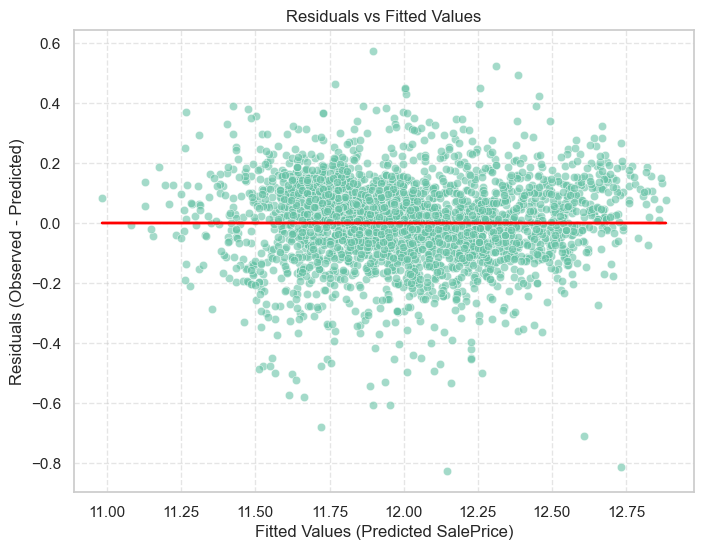

Correlation between fitted values and residuals: -0.0000
Linearity assumption seems reasonable (residuals uncorrelated with fitted values).


In [43]:
# =============================
# 1. Compute fitted values and residuals
# =============================
fitted_vals = result.fittedvalues
residuals = result.resid

# =============================
# 2. Plot residuals vs fitted values
# =============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predicted SalePrice)')
plt.ylabel('Residuals (Observed - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# =============================
# 3. Statistical validation (non-linearity pattern)
# =============================
corr = np.corrcoef(fitted_vals, residuals)[0,1]
print(f"Correlation between fitted values and residuals: {corr:.4f}")
if abs(corr) > 0.1:
    print("Possible non-linearity detected (residuals correlated with fitted values).")
else:
    print("Linearity assumption seems reasonable (residuals uncorrelated with fitted values).")

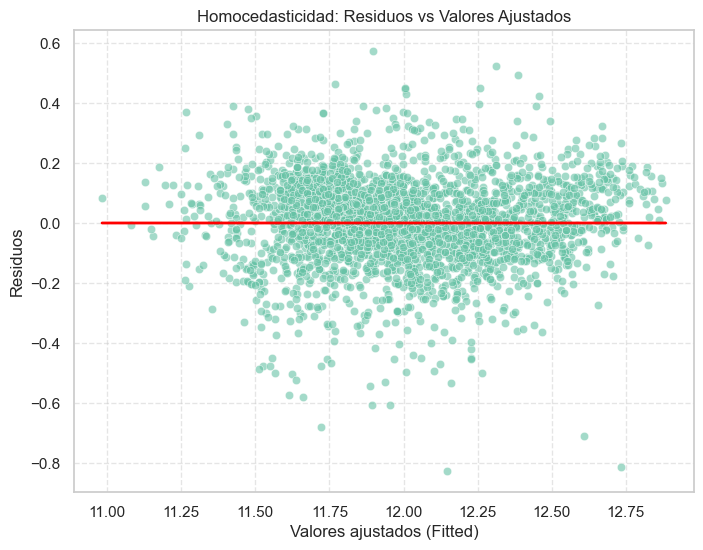


🔹 Resultados Test de Breusch–Pagan:
Lagrange multiplier statistic: 132.22236
p-value: 0.00000
f-value: 15.36546
f p-value: 0.00000
Evidencia de heterocedasticidad (p < 0.05)

🔹 Resultados Test de White:
LM Statistic: 238.25318
LM p-value: 0.00000
F-Statistic: 4.81918
F p-value: 0.00000
Evidencia de heterocedasticidad según White (p < 0.05)


In [44]:
# =============================
# 4. Visualización: Residuos vs Valores ajustados
# =============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Homocedasticidad: Residuos vs Valores Ajustados')
plt.xlabel('Valores ajustados (Fitted)')
plt.ylabel('Residuos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# =============================
# 5. Test de Breusch–Pagan
# =============================
bp_test = het_breuschpagan(residuals, X_1)

bp_labels = ['Lagrange multiplier statistic', 'p-value', 
             'f-value', 'f p-value']
print("\n🔹 Resultados Test de Breusch–Pagan:")
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.5f}")

if bp_test[1] < 0.05:
    print("Evidencia de heterocedasticidad (p < 0.05)")
else:
    print("No se detecta heterocedasticidad significativa")
    
# =============================
# 6. Test de White
# =============================
white_test = het_white(residuals, X_1)

white_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
print("\n🔹 Resultados Test de White:")
for name, val in zip(white_labels, white_test):
    print(f"{name}: {val:.5f}")

if white_test[1] < 0.05:
    print("Evidencia de heterocedasticidad según White (p < 0.05)")
else:
    print("No se detecta heterocedasticidad según White")

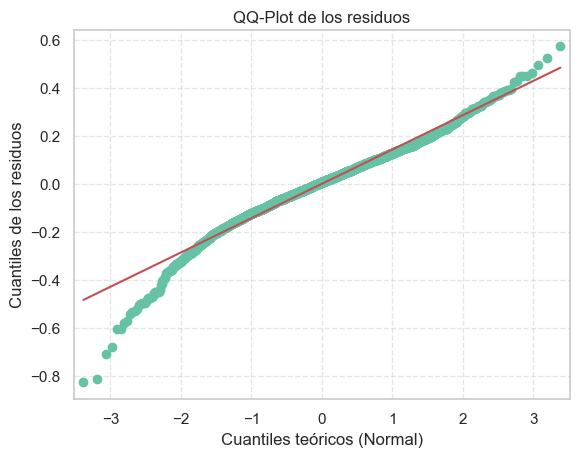

In [45]:
# =============================
# QQ Plot para evaluar normalidad
# =============================
sm.qqplot(residuals, line='s', color='blue')
plt.title("QQ-Plot de los residuos")
plt.xlabel("Cuantiles teóricos (Normal)")
plt.ylabel("Cuantiles de los residuos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



Estadístico de Durbin–Watson: 1.6549
No hay evidencia fuerte de autocorrelación (residuos independientes).


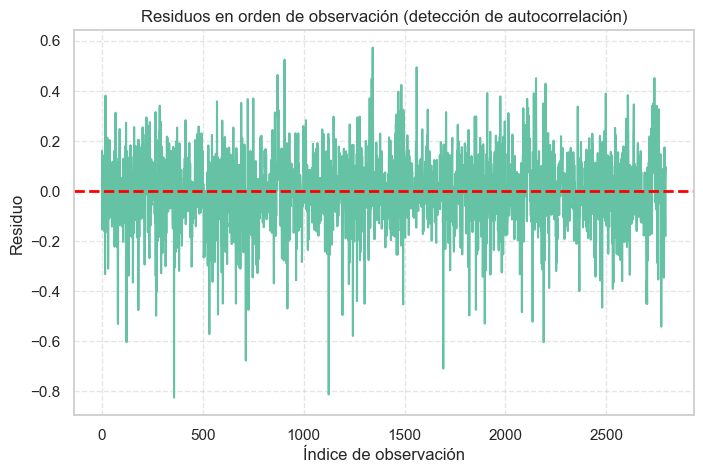

In [46]:
# =============================
# 4. Calcular estadístico de Durbin–Watson
# =============================
dw_stat = durbin_watson(residuals)
print(f"\nEstadístico de Durbin–Watson: {dw_stat:.4f}")

# =============================
# 5. Interpretación
# =============================
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación (residuos independientes).")

# =============================
# 6. Visualización: residuos vs índice (orden de observación)
# =============================
plt.figure(figsize=(8,5))
sns.lineplot(x=range(len(residuals)), y=residuals)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Residuos en orden de observación (detección de autocorrelación)")
plt.xlabel("Índice de observación")
plt.ylabel("Residuo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [47]:
vif_data = pd.DataFrame()
vif_data["Variable"] = ['const'] + regressor_columns_def
vif_data["VIF"] = [variance_inflation_factor(X_1, i) for i in range(X_1.shape[1])]

print("\nFactores de inflación de la varianza (VIF):")
print(vif_data)

# =============================
# 3. Interpretación
# =============================
print("\nInterpretación:")
for var, vif in zip(vif_data["Variable"], vif_data["VIF"]):
    if vif < 5:
        print(f"{var}: Sin multicolinealidad significativa (VIF={vif:.2f})")
    elif vif < 10:
        print(f"{var}: Multicolinealidad moderada (VIF={vif:.2f})")
    else:
        print(f"{var}: Alta multicolinealidad (VIF={vif:.2f}) — considerar eliminar o combinar variables.")


Factores de inflación de la varianza (VIF):
           Variable           VIF
0             const  27289.559317
1      Overall Qual      2.396311
2       Gr Liv Area      2.367375
3       Garage Area      1.743408
4        Year Built      3.495731
5        1st Flr SF      1.478844
6    Year Remod/Add      1.982134
7         Full Bath      2.137721
8  Foundation_PConc      2.152914
9     Garage Yr Blt      3.375868

Interpretación:
const: Alta multicolinealidad (VIF=27289.56) — considerar eliminar o combinar variables.
Overall Qual: Sin multicolinealidad significativa (VIF=2.40)
Gr Liv Area: Sin multicolinealidad significativa (VIF=2.37)
Garage Area: Sin multicolinealidad significativa (VIF=1.74)
Year Built: Sin multicolinealidad significativa (VIF=3.50)
1st Flr SF: Sin multicolinealidad significativa (VIF=1.48)
Year Remod/Add: Sin multicolinealidad significativa (VIF=1.98)
Full Bath: Sin multicolinealidad significativa (VIF=2.14)
Foundation_PConc: Sin multicolinealidad significativa (

# 7. Remedios y métodos robustos

## 7.1 HC0–HC3: Correcciones para heterocedasticidad

In [48]:
print("\nModelos con corrección robusta a heterocedasticidad: HCO")
robust_model = result.get_robustcov_results(cov_type='HC0')
print(f"\n=== Resultados con HC0 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HCO

=== Resultados con HC0 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1706.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                 1473.3
No. Observations:                2796   AIC:                            -2927.
Df Residuals:                    2786   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5335      0.524     -1.018      0.309      -1.561       0.494
x1             0.0940      0.004     26.756      0.000       0.087       0.101
x2             0.3914      0.015     26.553      0.000       0.362       0.420
x3             0.0003   2.22e-05     11.831      0.000       0.000       0.000
x4             0.0025      0.000     13.099      0.000       0.002       0.003
x5             0.2030      0.011     18.383      0.000       0.181       0.225
x6             0.0024      0.000     11.546      0.000       0.002       0.003
x7            -0.0405      0.008     -4.787      0.000      -0.057      -0.024
x8             0.0187      0.009      2.122      0.034       0.001       0.036
x9            -0.0010      0.000     -4.052      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      266.772   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.040
Skew:                          -0.526   Prob(JB):                    3.63e-158
Kurtosis:                       5.262   Cond. No.                     5.71e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
print("\nModelos con corrección robusta a heterocedasticidad: HC1")
robust_model = result.get_robustcov_results(cov_type='HC1')
print(f"\n=== Resultados con HC1 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC1

=== Resultados con HC1 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1700.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                 1473.3
No. Observations:                2796   AIC:                            -2927.
Df Residuals:                    2786   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5335      0.525     -1.016      0.310      -1.563       0.496
x1             0.0940      0.004     26.708      0.000       0.087       0.101
x2             0.3914      0.015     26.505      0.000       0.362       0.420
x3             0.0003   2.22e-05     11.810      0.000       0.000       0.000
x4             0.0025      0.000     13.075      0.000       0.002       0.003
x5             0.2030      0.011     18.350      0.000       0.181       0.225
x6             0.0024      0.000     11.526      0.000       0.002       0.003
x7            -0.0405      0.008     -4.778      0.000      -0.057      -0.024
x8             0.0187      0.009      2.119      0.034       0.001       0.036
x9            -0.0010      0.000     -4.045      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      266.772   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.040
Skew:                          -0.526   Prob(JB):                    3.63e-158
Kurtosis:                       5.262   Cond. No.                     5.71e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
print("\nModelos con corrección robusta a heterocedasticidad: HC2")
robust_model = result.get_robustcov_results(cov_type='HC2')
print(f"\n=== Resultados con HC2 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC2

=== Resultados con HC2 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1699.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                 1473.3
No. Observations:                2796   AIC:                            -2927.
Df Residuals:                    2786   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5335      0.526     -1.015      0.310      -1.564       0.497
x1             0.0940      0.004     26.680      0.000       0.087       0.101
x2             0.3914      0.015     26.485      0.000       0.362       0.420
x3             0.0003   2.23e-05     11.790      0.000       0.000       0.000
x4             0.0025      0.000     13.041      0.000       0.002       0.003
x5             0.2030      0.011     18.337      0.000       0.181       0.225
x6             0.0024      0.000     11.509      0.000       0.002       0.003
x7            -0.0405      0.008     -4.771      0.000      -0.057      -0.024
x8             0.0187      0.009      2.116      0.034       0.001       0.036
x9            -0.0010      0.000     -4.035      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      266.772   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.040
Skew:                          -0.526   Prob(JB):                    3.63e-158
Kurtosis:                       5.262   Cond. No.                     5.71e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
print("\nModelos con corrección robusta a heterocedasticidad: HC3")
robust_model = result.get_robustcov_results(cov_type='HC3')
print(f"\n=== Resultados con HC3 ===")
robust_model.summary()


Modelos con corrección robusta a heterocedasticidad: HC3

=== Resultados con HC3 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1693.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                 1473.3
No. Observations:                2796   AIC:                            -2927.
Df Residuals:                    2786   BIC:                            -2867.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5335      0.527     -1.012      0.312      -1.568       0.501
x1             0.0940      0.004     26.605      0.000       0.087       0.101
x2             0.3914      0.015     26.417      0.000       0.362       0.420
x3             0.0003   2.24e-05     11.750      0.000       0.000       0.000
x4             0.0025      0.000     12.983      0.000       0.002       0.003
x5             0.2030      0.011     18.292      0.000       0.181       0.225
x6             0.0024      0.000     11.473      0.000       0.002       0.003
x7            -0.0405      0.009     -4.755      0.000      -0.057      -0.024
x8             0.0187      0.009      2.109      0.035       0.001       0.036
x9            -0.0010      0.000     -4.018      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      266.772   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              725.040
Skew:                          -0.526   Prob(JB):                    3.63e-158
Kurtosis:                       5.262   Cond. No.                     5.71e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 7.2 RLM: Modelos robustos con funciones Huber/Tukey

In [52]:
# =============================
# 3. Ajustar modelo RLM (Regresión Lineal Robusta)
# =============================
rlm_model = sm.RLM(Y, X_1, M=HuberT())  # Puedes probar otros: HuberT(), TukeyBiweight(), Andrews()
rlm_results = rlm_model.fit()

# =============================
# 4. Mostrar resultados
# =============================
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 2796
Model:                            RLM   Df Residuals:                     2786
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        20:45:14                                         
No. Iterations:                    21                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5185      0.407     -1.274      0.2

## 7.3 Bootstrap

In [53]:
# =============================
# 3. Parámetros del bootstrap
# =============================
n_bootstraps = 1000
coefficients = []

# =============================
# 4. Loop de bootstrap
# =============================
for i in range(n_bootstraps):
    # Re-muestreo con reemplazo
    X_res, y_res = resample(X_1, Y, replace=True, random_state=i)
    
    # Ajustar modelo OLS
    model = sm.OLS(y_res, X_res).fit()
    
    # Guardar coeficientes
    coefficients.append(model.params)

# Convertir a DataFrame
boot_df = pd.DataFrame(coefficients, columns=['const'] + regressor_columns_def)

# =============================
# 5. Estadísticos del bootstrap
# =============================
boot_summary = pd.DataFrame({
    "Media": boot_df.mean(),
    "Desviación Std": boot_df.std(),
    "IC 2.5%": boot_df.quantile(0.025),
    "IC 97.5%": boot_df.quantile(0.975)
})

print("\n📊 Resultados del Bootstrap (1000 réplicas):")
print(boot_summary)


📊 Resultados del Bootstrap (1000 réplicas):
                     Media  Desviación Std   IC 2.5%  IC 97.5%
const            -0.546672        0.526154 -1.547253  0.495994
Overall Qual      0.093827        0.003658  0.086749  0.101128
Gr Liv Area       0.391777        0.014693  0.362013  0.420007
Garage Area       0.000262        0.000022  0.000222  0.000306
Year Built        0.002490        0.000188  0.002110  0.002854
1st Flr SF        0.202926        0.010939  0.181148  0.224568
Year Remod/Add    0.002373        0.000206  0.001971  0.002800
Full Bath        -0.040520        0.008609 -0.057234 -0.025407
Foundation_PConc  0.018484        0.008864  0.000845  0.035548
Garage Yr Blt    -0.000987        0.000244 -0.001467 -0.000477


## 7.4 Tabla Comparativa

### 7.4.1 Error Estándar

In [54]:
comparison_se = pd.DataFrame({
    'HC3_SE': robust_model.bse,
    'RLM_SE': rlm_results.bse,
    'Bootstrap_SE': boot_df.std()
})

comparison_se

,HC3_SE,RLM_SE,Bootstrap_SE
const,0.527412,0.407137,0.526154
Overall Qual,0.003533,0.002916,0.003658
Gr Liv Area,0.014815,0.012581,0.014693
Garage Area,0.000022,0.000017,0.000022
Year Built,0.000192,0.000157,0.000188
1st Flr SF,0.011098,0.009824,0.010939
Year Remod/Add,0.000206,0.000168,0.000206
Full Bath,0.008512,0.006735,0.008609
Foundation_PConc,0.008868,0.007280,0.008864
Garage Yr Blt,0.000245,0.000189,0.000244


### 7.4.2 Amplitud de intervalos de confianza

In [55]:
ols_ci = robust_model.conf_int(alpha=0.05)

ols_width = ols_ci[:,1] - ols_ci[:,0]

ols_width

array([2.06831728, 0.01385676, 0.05810093, 0.00008766, 0.00075115,
       0.04352185, 0.00080971, 0.0333816 , 0.03477754, 0.00096221])

In [56]:
rlm_ci = rlm_results.conf_int(alpha=0.05)

rlm_width = rlm_ci[:,1] - rlm_ci[:,0]

rlm_width

array([1.59594934, 0.01142892, 0.04931851, 0.00006513, 0.00061525,
       0.03851076, 0.00065761, 0.02640216, 0.02853589, 0.00073959])

In [57]:
bootstrap_width = boot_df.quantile(0.975) - boot_df.quantile(0.025)

bootstrap_width

const               2.043247
Overall Qual        0.014379
Gr Liv Area         0.057994
Garage Area         0.000084
Year Built          0.000744
1st Flr SF          0.043420
Year Remod/Add      0.000830
Full Bath           0.031827
Foundation_PConc    0.034703
Garage Yr Blt       0.000990
dtype: float64

In [58]:
comparison_ICwidth = pd.DataFrame({
    'HC3': ols_width,
    'RLM': rlm_width,
    'Bootstrap': bootstrap_width
})

comparison_ICwidth

,HC3,RLM,Bootstrap
const,2.068317,1.595949,2.043247
Overall Qual,0.013857,0.011429,0.014379
Gr Liv Area,0.058101,0.049319,0.057994
Garage Area,0.000088,0.000065,0.000084
Year Built,0.000751,0.000615,0.000744
1st Flr SF,0.043522,0.038511,0.043420
Year Remod/Add,0.000810,0.000658,0.000830
Full Bath,0.033382,0.026402,0.031827
Foundation_PConc,0.034778,0.028536,0.034703
Garage Yr Blt,0.000962,0.000740,0.000990


### 7.4.3 Comparación de coeficientes

In [59]:
comparison_coeff = pd.DataFrame({
    'HC3': robust_model.params,
    'RLM': rlm_results.params,
    'Bootstrap': boot_df.mean()
})

comparison_coeff

,HC3,RLM,Bootstrap
const,-0.533525,-0.518491,-0.546672
Overall Qual,0.094005,0.091251,0.093827
Gr Liv Area,0.391375,0.397367,0.391777
Garage Area,0.000263,0.000267,0.000262
Year Built,0.002487,0.002434,0.002490
1st Flr SF,0.203003,0.207115,0.202926
Year Remod/Add,0.002369,0.002242,0.002373
Full Bath,-0.040479,-0.036084,-0.040520
Foundation_PConc,0.018704,0.010598,0.018484
Garage Yr Blt,-0.000986,-0.000843,-0.000987


# 8. Validación y selección de modelo

## 8.1 Creación de set de entrenamiento y prueba

In [60]:
X = df_final[regressor_columns_def].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

# =============================
# 3. Standardize features
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================
# 4. Add intercept
# =============================
# Add a column of ones to represent the intercept
X_train_std = np.column_stack((np.ones(X_train_scaled.shape[0]), X_train_scaled))
X_test_std = np.column_stack((np.ones(X_test_scaled.shape[0]), X_test_scaled))

In [61]:
X_train.shape

(2236, 9)

In [62]:
X_test.shape

(560, 9)

## 8.2 Creación de función de evaluación

In [63]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    """
    Calcula métricas de desempeño y overfitting para un modelo de regresión.

    Parámetros:
    -----------
    modelo : objeto ya entrenado (fit)
        Debe tener método .predict()
    X_train, y_train : datos de entrenamiento
    X_test, y_test   : datos de prueba

    Retorna:
    --------
    resultados : pd.DataFrame
        R², RMSE y MAE en train y test + diferencia (overfitting)
    predicciones : pd.DataFrame
        DataFrame con y_real, y_predicho y residuales (para test)
    """

    # =============================
    # 1. Predicciones
    # =============================
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # =============================
    # 2. Métricas de desempeño
    # =============================
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # =============================
    # 3. Overfitting
    # =============================
    overfit_r2 = r2_train - r2_test
    overfit_rmse = rmse_test - rmse_train

    # =============================
    # 4. DataFrame resumen
    # =============================
    resultados = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'Entrenamiento': [r2_train, rmse_train, mae_train],
        'Prueba': [r2_test, rmse_test, mae_test],
        'Diferencia (Overfitting)': [overfit_r2, overfit_rmse, mae_test - mae_train]
    })

    # =============================
    # 5. DataFrame de predicciones
    # =============================
    predicciones = pd.DataFrame({
        'y_real': y_test.flatten(),
        'y_predicho': y_test_pred.flatten(),
        'residuo': (y_test.flatten() - y_test_pred.flatten())
    })

    return resultados, predicciones

## 8.3 Comparación OLS vs RIDGE vs Lasso (Modificado)

### 8.3.1 OLS

In [64]:
reg = LinearRegression().fit(X_train_std, y_train)

In [65]:
resultados, predicciones = evaluar_modelo(reg, X_train_std,y_train, X_test_std, y_test)

In [66]:
ols_test = resultados['Prueba']
ols_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.841145,0.854205,-0.013060
1,RMSE,0.142595,0.144324,0.001729
2,MAE,0.106789,0.108900,0.002110


In [67]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.288062,-0.128028
1,12.429220,12.332032,0.097189
2,12.146859,12.111758,0.035101
3,11.561725,11.511587,0.050138
4,12.061053,12.180136,-0.119084
...,...,...,...
555,12.146859,12.253651,-0.106792
556,12.429220,12.378125,0.051095
557,12.404928,12.200422,0.204506
558,11.872354,11.851718,0.020636


### 8.3.2 Ridge Regression

In [68]:
# ========================================
# 1. Split training data into train/validation
# ========================================
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_std, y_train, test_size=0.2, random_state=random_state
)

# ========================================
# 2. Define range of lambdas (alphas)
# ========================================
lambdas = np.logspace(-3, 3, 50)  # from 10^-3 to 10^3 (50 points)

# Store results
results = []

# ========================================
# 3. Train Ridge model for each lambda
# ========================================
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_train_sub, y_train_sub)
    
    resultados, predicciones = evaluar_modelo(ridge, X_train_sub,y_train_sub, X_val, y_val)

    r2_val = resultados['Prueba'][0]
    rmse_val = resultados['Prueba'][1]
    
    results.append({'Lambda': lam, 'R2_Validation': r2_val, 'RMSE_Validation': rmse_val})

# ========================================
# 4. Collect results in a DataFrame
# ========================================
results_df = pd.DataFrame(results)

# Identify best lambda (highest R²)
best_row = results_df.loc[results_df['R2_Validation'].idxmax()]
best_lambda = best_row['Lambda']

In [69]:
best_lambda

np.float64(79.06043210907701)

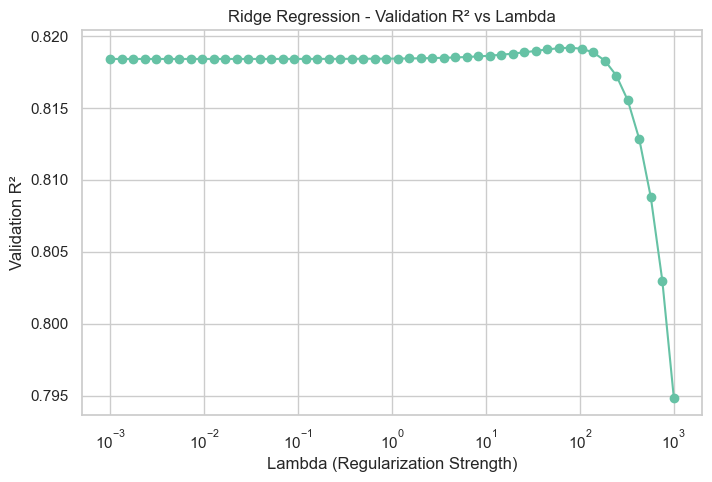

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.semilogx(results_df['Lambda'], results_df['R2_Validation'], marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Validation R²')
plt.title('Ridge Regression - Validation R² vs Lambda')
plt.grid(True)
plt.show()

In [71]:
# ========================================
# 5. Train final Ridge model on full training set
# ========================================
ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_train_std, y_train)

,alpha,np.float64(79.06043210907701)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [72]:
resultados, predicciones = evaluar_modelo(ridge_best, X_train_std,y_train, X_test_std, y_test)

In [73]:
ridge_test = resultados['Prueba']
ridge_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.840641,0.853327,-0.012687
1,RMSE,0.142821,0.144757,0.001937
2,MAE,0.106730,0.109228,0.002498


In [74]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.288716,-0.128682
1,12.429220,12.321204,0.108016
2,12.146859,12.112536,0.034322
3,11.561725,11.516373,0.045352
4,12.061053,12.178601,-0.117549
...,...,...,...
555,12.146859,12.255199,-0.108340
556,12.429220,12.374939,0.054282
557,12.404928,12.197229,0.207698
558,11.872354,11.852659,0.019695


### 8.3.3 Lasso Regression

In [75]:
# ========================================
# 1. Split training data into train/validation
# ========================================
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_std, y_train, test_size=0.2, random_state=random_state
)

# ========================================
# 2. Define range of lambdas (alphas)
# ========================================
lambdas = np.logspace(-3, 3, 50)  # from 10^-3 to 10^3 (50 points)

# Store results
results = []

# ========================================
# 3. Train lasso model for each lambda
# ========================================
for lam in lambdas:
    lasso = Lasso(alpha=lam)
    lasso.fit(X_train_sub, y_train_sub)
    
    resultados, predicciones = evaluar_modelo(lasso, X_train_sub,y_train_sub, X_val, y_val)

    r2_val = resultados['Prueba'][0]
    rmse_val = resultados['Prueba'][1]
    
    results.append({'Lambda': lam, 'R2_Validation': r2_val, 'RMSE_Validation': rmse_val})

# ========================================
# 4. Collect results in a DataFrame
# ========================================
results_df = pd.DataFrame(results)

# Identify best lambda (highest R²)
best_row = results_df.loc[results_df['R2_Validation'].idxmax()]
best_lambda = best_row['Lambda']

In [76]:
best_lambda

np.float64(0.001)

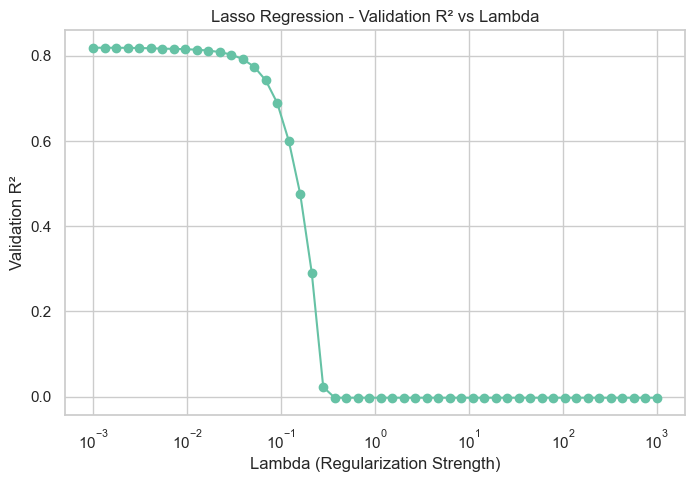

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.semilogx(results_df['Lambda'], results_df['R2_Validation'], marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Validation R²')
plt.title('Lasso Regression - Validation R² vs Lambda')
plt.grid(True)
plt.show()

In [78]:
# ========================================
# 5. Train final Lasso model on full training set
# ========================================
lasso_best = Lasso(alpha=best_lambda)
lasso_best.fit(X_train_std, y_train)

,alpha,np.float64(0.001)
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [79]:
resultados, predicciones = evaluar_modelo(lasso_best, X_train_std,y_train, X_test_std, y_test)

In [80]:
lasso_test = resultados['Prueba']
lasso_overfitting = resultados['Diferencia (Overfitting)']
resultados

,Métrica,Entrenamiento,Prueba,Diferencia (Overfitting)
0,R²,0.840989,0.853627,-0.012638
1,RMSE,0.142665,0.144609,0.001945
2,MAE,0.106749,0.109007,0.002259


In [81]:
predicciones

,y_real,y_predicho,residuo
0,12.160034,12.288330,-0.128296
1,12.429220,12.328672,0.100548
2,12.146859,12.113353,0.033506
3,11.561725,11.510477,0.051248
4,12.061053,12.180512,-0.119459
...,...,...,...
555,12.146859,12.255194,-0.108335
556,12.429220,12.383137,0.046083
557,12.404928,12.198788,0.206139
558,11.872354,11.853307,0.019047


In [82]:
lasso_best.coef_

array([ 0.        ,  0.1238554 ,  0.1126418 ,  0.04602867,  0.06926484,
        0.06245571,  0.04923303, -0.01658052,  0.00566151, -0.01784137])

### 8.3.4 Comparativa

In [83]:
comparativa_test = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'OLS': ols_test,
        'Ridge': ridge_test,
        'Lasso': lasso_test
    })

comparativa_test

,Métrica,OLS,Ridge,Lasso
0,R²,0.854205,0.853327,0.853627
1,RMSE,0.144324,0.144757,0.144609
2,MAE,0.108900,0.109228,0.109007


In [84]:
comparativa_overfitting = pd.DataFrame({
        'Métrica': ['R²', 'RMSE', 'MAE'],
        'OLS': ols_overfitting,
        'Ridge': ridge_overfitting,
        'Lasso': lasso_overfitting
    })

comparativa_overfitting

,Métrica,OLS,Ridge,Lasso
0,R²,-0.013060,-0.012687,-0.012638
1,RMSE,0.001729,0.001937,0.001945
2,MAE,0.002110,0.002498,0.002259
